# Long Short Term Memory (LSTM)

## Data import

In [1]:
from sklearn.model_selection import train_test_split
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
import numpy as np
from sklearn.metrics import classification_report

In [2]:
df = pd.read_csv("data/Corona_NLP.csv", encoding='latin-1')
pd.options.display.max_colwidth = 500
df.head(10)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate supplies of regular meds but not over order,Positive
2,3801,48753,Vagabonds,16-03-2020,"Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P",Positive
3,3802,48754,NaN,16-03-2020,"My food stock is not the only one which is empty...\r\r\n\r\r\nPLEASE, don't panic, THERE WILL BE ENOUGH FOOD FOR EVERYONE if you do not take more than you need. \r\r\nStay calm, stay safe.\r\r\n\r\r\n#COVID19france #COVID_19 #COVID19 #coronavirus #confinement #Confinementotal #ConfinementGeneral https://t.co/zrlG0Z520j",Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COVID19 outbreak.\r\r\n\r\r\nNot because I'm paranoid, but because my food stock is litteraly empty. The #coronavirus is a serious thing, but please, don't panic. It causes shortage...\r\r\n\r\r\n#CoronavirusFrance #restezchezvous #StayAtHome #confinement https://t.co/usmuaLq72n",Extremely Negative
5,3804,48756,"ÃT: 36.319708,-82.363649",16-03-2020,"As news of the regionÂs first confirmed COVID-19 case came out of Sullivan County last week, people flocked to area stores to purchase cleaning supplies, hand sanitizer, food, toilet paper and other goods, @Tim_Dodson reports https://t.co/cfXch7a2lU",Positive
6,3805,48757,"35.926541,-78.753267",16-03-2020,"Cashier at grocery store was sharing his insights on #Covid_19 To prove his credibility he commented ""I'm in Civics class so I know what I'm talking about"". https://t.co/ieFDNeHgDO",Positive
7,3806,48758,Austria,16-03-2020,Was at the supermarket today. Didn't buy toilet paper. #Rebel\r\r\n\r\r\n#toiletpapercrisis #covid_19 https://t.co/eVXkQLIdAZ,Neutral
8,3807,48759,"Atlanta, GA USA",16-03-2020,"Due to COVID-19 our retail store and classroom in Atlanta will not be open for walk-in business or classes for the next two weeks, beginning Monday, March 16. We will continue to process online and phone orders as normal! Thank you for your understanding! https://t.co/kw91zJ5O5i",Positive
9,3808,48760,"BHAVNAGAR,GUJRAT",16-03-2020,"For corona prevention,we should stop to buy things with the cash and should use online payment methods because corona can spread through the notes. Also we should prefer online shopping from our home. It's time to fight against COVID 19?. #govindia #IndiaFightsCorona",Negative


In [3]:
df  = df[['OriginalTweet', 'Sentiment']].head(10000)

In [4]:
set(df['Sentiment'].values)

{'Extremely Negative', 'Extremely Positive', 'Negative', 'Neutral', 'Positive'}

In [5]:
df['LabelSentiment'] = df['Sentiment'].apply(lambda x: 1 if x in ['Extremely Positive', 'Positive', 'Neutral'] else 0)

In [6]:
df.head()

,OriginalTweet,Sentiment,LabelSentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8,Neutral,1
1,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate supplies of regular meds but not over order,Positive,1
2,"Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P",Positive,1
3,"My food stock is not the only one which is empty...\r\r\n\r\r\nPLEASE, don't panic, THERE WILL BE ENOUGH FOOD FOR EVERYONE if you do not take more than you need. \r\r\nStay calm, stay safe.\r\r\n\r\r\n#COVID19france #COVID_19 #COVID19 #coronavirus #confinement #Confinementotal #ConfinementGeneral https://t.co/zrlG0Z520j",Positive,1
4,"Me, ready to go at supermarket during the #COVID19 outbreak.\r\r\n\r\r\nNot because I'm paranoid, but because my food stock is litteraly empty. The #coronavirus is a serious thing, but please, don't panic. It causes shortage...\r\r\n\r\r\n#CoronavirusFrance #restezchezvous #StayAtHome #confinement https://t.co/usmuaLq72n",Extremely Negative,0


<Axes: >

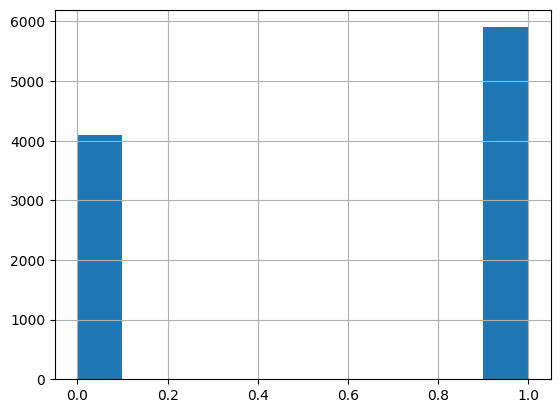

In [7]:
df['LabelSentiment'].hist()

## Train - Test split

In [8]:
X_train, X_test, Y_train, Y_test = train_test_split(df['OriginalTweet'], df['LabelSentiment'], test_size=0.20, random_state=4)

In [9]:
len(X_train), len(X_test), len(Y_train), len(Y_test)

(8000, 2000, 8000, 2000)

## Clean Text

In [10]:
stop = set(stopwords.words('english'))
stemmer = SnowballStemmer('english')
lemma = WordNetLemmatizer()

In [11]:
X_train_ = X_train.copy()

In [12]:
from tqdm import tqdm
def clean(text_list):
    
    updates = []
    
    for j in tqdm(text_list):
        
        text = j
        
        #LOWERCASE TEXT
        text = text.lower()
        
        #REMOVE NUMERICAL DATA and PUNCTUATION
        text = re.sub("[^a-zA-Z]"," ", text )
        
        #REMOVE STOPWORDS
        text = " ".join([word for word in text.split() if word not in stop])
        
        #Lemmatize
        text = " ".join(lemma.lemmatize(word) for word in text.split())
            
        updates.append(text)
        
    return updates

In [13]:
x_train = clean(X_train)

100%|██████████| 8000/8000 [00:01<00:00, 5630.14it/s]


In [14]:
x_test = clean(X_test)

100%|██████████| 2000/2000 [00:00<00:00, 15163.08it/s]


In [15]:
y_train = Y_train.to_numpy()

In [16]:
y_test = Y_test.to_numpy()

## Feature Engineering (Word Embeddings)

In [17]:
#!pip install gensim
import gensim.downloader

In [18]:
print(list(gensim.downloader.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [19]:
w2v = gensim.downloader.load('glove-twitter-100')

In [20]:
def corpus2vec(corpus):
    corpus_vec = []
    for document in tqdm(corpus):
        #get word vectors for each document
        doc_vectors = []
        for word in document.split():
            if word in w2v.index_to_key:
                doc_vectors.append(w2v.word_vec(word))         
        corpus_vec.append(doc_vectors)
    return corpus_vec

In [21]:
x_train_vec = corpus2vec(x_train)

/tmp/ipykernel_2267752/1283255324.py:8: DeprecationWarning: Call to deprecated `word_vec` (Use get_vector instead).
  doc_vectors.append(w2v.word_vec(word))


In [22]:
x_test_vec = corpus2vec(x_test)

/tmp/ipykernel_2267752/1283255324.py:8: DeprecationWarning: Call to deprecated `word_vec` (Use get_vector instead).
  doc_vectors.append(w2v.word_vec(word))


## Pad Sequences

In [26]:
#!pip install tensorflow
import tensorflow as tf
tf.config.run_functions_eagerly(True)
tf.data.experimental.enable_debug_mode()

In [27]:
from keras.preprocessing.sequence import pad_sequences

In [28]:
train_len = []
for i in x_train_vec:
    train_len.append(len(i))
max(train_len)

48

In [29]:
#train_len

In [30]:
X_pad = pad_sequences(maxlen=48,sequences=x_train_vec, padding="post", dtype='float64')

In [31]:
X = tf.convert_to_tensor(X_pad, dtype='float32')

2022-03-21 16:59:46.266496: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-21 16:59:46.634629: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4654 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1660 Ti, pci bus id: 0000:07:00.0, compute capability: 7.5


In [32]:
X.shape

TensorShape([8000, 48, 100])

In [33]:
y = tf.one_hot(y_train, depth=2) # we predict only 0 or 2 for sentiment, so depth=2

## Model Initiation and Train (LSTM)

Understanding LSTM Networks: https://colah.github.io/posts/2015-08-Understanding-LSTMs/

Illustrated Guide to LSTM’s and GRU’s: A step by step explanation: https://towardsdatascience.com/illustrated-guide-to-lstms-and-gru-s-a-step-by-step-explanation-44e9eb85bf21

![LSTM](https://www.researchgate.net/publication/335524542/figure/fig11/AS:798002683842580@1567270074253/Mozilla-DeepSpeech-forward-LSTM-chain-this-should-the-only-used-part-after-mozillas.ppm)

In [34]:
tf.random.set_seed(221)
from keras.models import Model, Input
from keras.layers import LSTM, Dense, TimeDistributed, Bidirectional, Masking
from tensorflow.keras import layers

In [35]:
'''model input in the shape(number of words per doc, word embedding size)'''
input_ = Input(shape=(48,100))

'''mask layer to avoid model from considering padding vectors'''
mask_layer = Masking(mask_value=0)
mask = mask_layer(input_)

'''BiLSTM layer'''

lstm = Bidirectional(LSTM(units=4))(mask)

'''activation layer'''
act = Dense(2, activation='sigmoid')(lstm)

'''model input and output'''
model = Model(input_, act)

'''model loss function and evaluation metrics'''
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["binary_accuracy"])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 100)]         0         
                                                                 
 masking (Masking)           (None, 48, 100)           0         
                                                                 
 bidirectional (Bidirectiona  (None, 8)                3360      
 l)                                                              
                                                                 
 dense (Dense)               (None, 2)                 18        
                                                                 
Total params: 3,378
Trainable params: 3,378
Non-trainable params: 0
_________________________________________________________________


In [36]:
X.shape

TensorShape([8000, 48, 100])

In [37]:
history = model.fit(X, y, batch_size=16, epochs=20, verbose=1, validation_split=0.20)

Epoch 1/20


2022-03-21 17:39:31.304445: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8202


400/400 [==============================] - 14s 32ms/step - loss: 0.6305 - binary_accuracy: 0.6377 - val_loss: 0.5506 - val_binary_accuracy: 0.7297
Epoch 2/20
400/400 [==============================] - 13s 32ms/step - loss: 0.5326 - binary_accuracy: 0.7337 - val_loss: 0.5064 - val_binary_accuracy: 0.7613
Epoch 3/20
400/400 [==============================] - 13s 32ms/step - loss: 0.4883 - binary_accuracy: 0.7666 - val_loss: 0.4828 - val_binary_accuracy: 0.7750
Epoch 4/20
400/400 [==============================] - 13s 32ms/step - loss: 0.4577 - binary_accuracy: 0.7859 - val_loss: 0.4710 - val_binary_accuracy: 0.7847
Epoch 5/20
400/400 [==============================] - 13s 32ms/step - loss: 0.4366 - binary_accuracy: 0.8020 - val_loss: 0.4588 - val_binary_accuracy: 0.7922
Epoch 6/20
400/400 [==============================] - 13s 32ms/step - loss: 0.4174 - binary_accuracy: 0.8134 - val_loss: 0.4567 - val_binary_accuracy: 0.7909
Epoch 7/20
400/400 [==============================] - 13s 32ms/

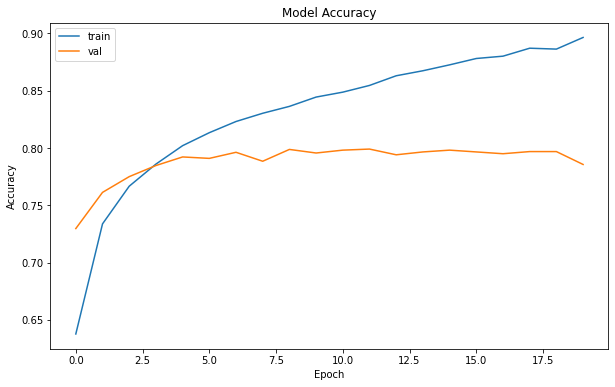

In [39]:
import matplotlib.pyplot as plt
plt.figure(figsize =(10, 6))
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Predict

In [40]:
X_test_pad = pad_sequences(maxlen=48,sequences=x_test_vec, padding="post", dtype='float64')

In [41]:
#x_test = np.expand_dims(x_test,-1)
x_test = tf.convert_to_tensor(X_test_pad, dtype='float32')

In [42]:
x_test.shape

TensorShape([2000, 48, 100])

In [43]:
pred_y = model.predict(x_test)

In [44]:
pred_y

array([[0.15682222, 0.8199296 ],
       [0.9812757 , 0.01731032],
       [0.00370222, 0.9958187 ],
       ...,
       [0.0059766 , 0.9929132 ],
       [0.91481006, 0.08032743],
       [0.4132031 , 0.58307976]], dtype=float32)

In [45]:
y_pred = []
for doc in pred_y:
    y_pred.append(np.argmax(doc, axis=None, out=None))

In [46]:
y_pred[0:10]

[1, 0, 1, 1, 1, 1, 1, 1, 0, 0]

In [47]:
y_test[0:10]

array([1, 0, 1, 1, 1, 0, 1, 0, 0, 0])

In [48]:
#y_test = tf.one_hot(y_test, depth=2)

In [49]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.75      0.75       814
           1       0.83      0.82      0.83      1186

    accuracy                           0.80      2000
   macro avg       0.79      0.79      0.79      2000
weighted avg       0.80      0.80      0.80      2000

